To run a cell : CTRL + Enter (in Jupyter notebook)

MIT License

Copyright (c) 2024 Liam Loizeau-Woollgar, Julien Pellen, Laurence Hubert-Moy

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [5]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import hiclass
import matplotlib.pyplot as plt
import rioxarray as rxr
import xarray as xr
import os


# Define paths for modeling data 

Please indicate filepaths for modeling outputs destination, input raster and a dataframe containing hierarchical class labels and extracted raster values for all samples.

Other necessary information are the names of columns containing the hierarchical labels of training samples, as well as the value taken by missing hierarchical labels. 

If input data is correctly prepared, this cell is the only part of the script requiring modifications.

In [18]:
##### Define paths and necessary information for modeling data 

# Path of dataframe containg class labels along with extracted raster values /!\ columns have to be in the same order as raster bands 
df_path = 'D:/heriarchical_classification/working_dir/Calupeyre_extracted_raster_values.csv'

# List of column names containing the hierarchical class labels
ylabel = ["level1", "level2", "level3"]

# Indicate the value taken by missing class labels at higher levels, missing class labels will be replaced by existing values at previous levels
# Example : if a sample is affected label 'A' at level 1 and 'A.1' at level 2, but has no affected class at higher levels, higher levels will be affected label 'A.1'  
# missing class values can also be left empty 
fillval = 'nolabel'

# Path of multiband raster used for mapped predictions 
raster_path = 'D:/heriarchical_classification/working_dir/Calupeyre_pred_variables.tif'

# Filepath for receiving outputs generated by the script (mapped predictions, accuracy metrics, confusion matrices, class dictionary for interpretation of raster maps)
# file will be created if missing
working_dir = 'D:/heriarchical_classification/working_dir/outputs'

if not os.path.exists(working_dir):
    os.makedirs(working_dir)

#### Automatically generate output paths

# Path for saving hiclass model as .sav file using pickle
modelpath = os.path.join(working_dir, "hiclass_model.sav")

# Output for saving raster map as .tif file
outraster =	os.path.join(working_dir, "classified_raster.tif")

# output for saving class dictionary as .csv
classdictpath = os.path.join(working_dir, "class_dict.csv")


# Importing modeling data

In [7]:
# Import dataframe for training and validation
df = pd.read_csv(df_path, sep = ",")

df

,level1,level2,level3,TPI_micro,TPI_meso,TPI_macro,Altitude,VDCNI,TWI,b2_FPCA_1,...,b7_FPCA_3,b8_FPCA_1,b8_FPCA_2,b8_FPCA_3,b10_FPCA_1,b10_FPCA_2,b10_FPCA_3,b11_FPCA_1,b11_FPCA_2,b11_FPCA_3
0,B,B1,B1.7,-1.220950,-0.919707,-0.811637,4.210000,3.625983,10.267284,-1141.891357,...,263.221497,-3133.460693,315.690887,574.212524,-4486.851074,76.873466,983.068359,-3754.072510,-103.416779,-840.841064
1,B,B1,B1.7,-0.856571,-0.868037,0.941485,29.879999,20.504025,11.047691,-1668.009155,...,1049.887939,-3000.622070,-2064.285645,1180.491211,-6539.078125,79.840881,447.734680,-4959.147949,-126.614510,-483.325012
2,E,E5,E5.3,0.282504,0.196285,-0.686604,45.130001,8.592548,6.849378,-1072.378174,...,683.757263,579.985779,3942.786865,975.609314,2965.243408,2389.304443,-792.030212,396.524017,-1777.291626,902.969177
3,I,I1,I1.1,0.509924,-0.310277,-0.415254,7.900000,5.285254,12.375029,3741.844971,...,-1480.818604,667.607605,1534.585693,-1702.905273,6861.510254,1967.069580,535.630066,7554.623047,-2523.116943,-473.900360
4,I,I1,I1.1,-0.763083,-0.781313,1.151222,61.790001,44.436668,9.618379,74.383675,...,-1959.213745,-536.775757,947.053467,-2033.796753,3032.625977,-240.041489,245.938248,3556.611816,-110.731003,-244.768707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,I,I1,I1.1,-1.602513,-1.973988,-1.889123,15.190000,0.242946,7.303044,-339.857483,...,1565.495728,7306.547363,-1151.002563,1440.936768,3630.497314,-334.888489,-1017.035950,976.289185,31.720440,832.282654
1625,I,I1,I1.1,-0.944465,-0.891212,-0.629883,29.700001,2.256725,8.209525,1110.090088,...,813.153870,4019.192139,-1504.559326,748.025635,5709.677734,1663.634277,2184.413818,5420.310059,-1718.943481,-2546.208984
1626,I,I1,I1.1,-1.311347,-1.412688,-1.527936,16.889999,0.531548,14.726502,-1046.855469,...,2652.090088,3812.082031,1511.357056,2749.190918,-307.169067,-39.127556,-1357.989868,-1502.594727,-183.628983,929.987427
1627,I,I1,I1.1,-0.502464,-0.199413,0.499539,42.200001,10.878172,8.778795,26.923073,...,708.518555,7277.115723,-3505.163818,505.951874,4224.230957,-1725.330688,-862.045593,1555.583252,1907.058472,846.670166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


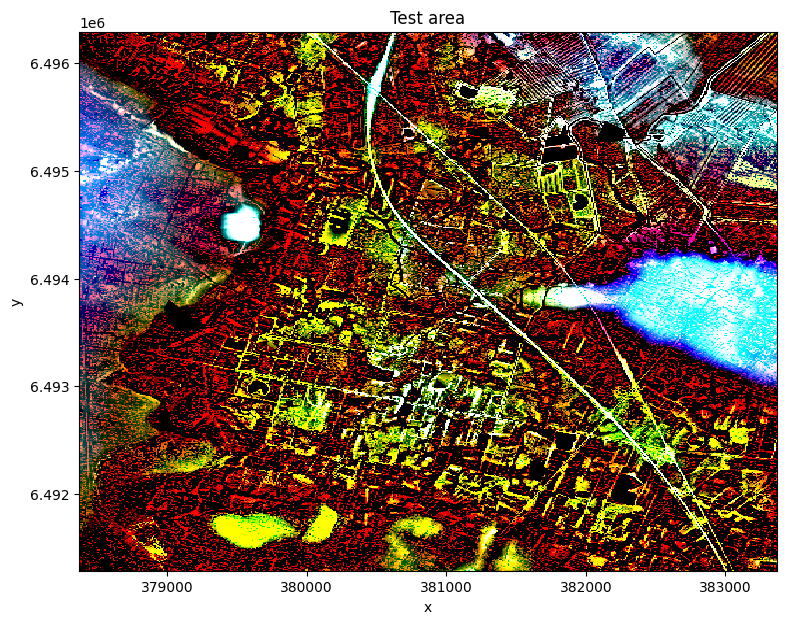

In [14]:
from rasterio.plot import show

##### Import and show raster

# open raster using rioxarray
im = rxr.open_rasterio(raster_path, masked=True).squeeze()

# Saving nan values mask
nan_mask = im.isnull()[0]

# Replacing raster nan values by 0 
im = im.fillna(0)

# Displaying the first 3 bands of our raster image as an RGB color composite 
#(in our test case, the first 3 bands are the topographical position index at micro, meso and macro scale)
im.sel(band=[1,2,3]).plot.imshow(rgb="band", figsize=(9, 7))
plt.title('Color composite display of input raster (first three bands)')
plt.show()



# Dataframe preparation, model training with k-fold validation 

- A 3 folds K-fold validation procedure is applied for evaluation of model performance, results are stored as data arrays to calculate evaluation metrics.
- The final model used for raster classification is trained on all available training data. 

In [15]:
### Replacing missing class labels by the existing lower level labels
# replace labels left as nan by fill value
df = df.fillna(str(fillval))

# Replace missing labels by previous available labels
for e in range(len(ylabel[1:])):
    for b in range(len(df)) :
        if df.iloc[b,e] == fillval :
            var = df.iloc[b,e-1]
            df.iloc[b,e] = var


### Deleting samples with rare class occurences
# Classes that are affected to less than 3 samples cannot be distributed amongst the 3 folds of k-fold cross-validation, and are thus deleted to allow accurate validation of the model 

# class levels are aggregated for counting
ar = np.array(df[ylabel])
y_agg = []
for i in range(ar.shape[0]) :
    y_agg.append((str(ar[i,0])+ str(ar[i,1])+ str(ar[i,2])))

# counting unique class occurences 
dhd = np.unique(y_agg, return_counts=True)
label_uu = np.ravel(dhd[0])
count_label = np.ravel(dhd[1])

# finding classes with 3 occurences or lower 
l_var = []
for e, i in zip(label_uu, count_label):
    if i <= 3 :
        l_var.append(e)

# Find indices of samples with rare class occurences in the orignal df
ind = []
for indice in range(len(l_var)) :
    for itr in range(len(y_agg)):

          # check the condition
        if(y_agg[itr] == l_var[indice]):
             ind.append(itr)

# delete samples with rare class occurences
df = df.drop(index=ind)

# update the array of aggregated class labels for generation of folds
ar = np.array(df[ylabel])
y_agg = []
for i in range(ar.shape[0]) :
    y_agg.append((str(ar[i,0])+ str(ar[i,1])+ str(ar[i,2])))


In [17]:
from sklearn.model_selection import StratifiedKFold

# Split explanatory and target variables
X, y = np.array(df.drop(columns=ylabel)), np.asarray(df[ylabel])

## Create hierarchical classifier based on random forest model
# The local classifier per parent node model method was used for this script, selecting another hierarchical classification method might require modifications 
from hiclass import LocalClassifierPerParentNode
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
classifier = LocalClassifierPerParentNode(local_classifier=rf, replace_classifiers=False)


# Implement Stratified k-fold method for cross-validation of model with preservation of class ratios amongst folds  
# Samples will be shuffled before splitting in folds to avoid potentil bias induced by the original ordering of rows in dataframe, modify if needed  
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Prepare lists of training results for later analysis
y_test = []
y_pred = []
y_train = []
X_train = []
X_test = []

# Training classifier following cross-validation procedure and storing results as arrays
for train, test in skf.split(X, y_agg):

    classifier.fit(X[train], y[train])

    pred = classifier.predict(X[test])

    y_test += list(y[test])
    y_pred += list(pred)
    y_train += list(y[train])
    X_train += list(X[train])
    X_test += list(X[test])


y_test = np.asarray(y_test)
y_pred = np.asarray(y_pred)
y_train = np.array(y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)


# Training final model on all available data
classifier.fit(X, y)


# Cell output is an information box displaying selected parameters for the hierarchical classifier and the embedded classifier

LocalClassifierPerParentNode(local_classifier=RandomForestClassifier(random_state=42),
                             replace_classifiers=False)

# Evaluate classifier : Hierarchical evaluation metrics, level-wise evaluation metrics, confusion matrices

Performance metrics are calculated by comparing the true and predicted classes for each sample, which were stored and concatenated as data arrays at each step of the K-fold cross-validation procedure. 

- Hierarchical performance metrics describe model performance over all levels
- Weighted performance metrics are used to describe performance at each level individually
- Confusion matrices are given for each level and exported as .csv to the working dir :
    - Columns show the counts of predicted class occurences
    - Rows show the counts of true class occurences
    - The final column shows classwise user's accuracy as a percentage (count of correctly classified samples in a class / total count of samples classified to that class )
    - The final row shows classwise producer's accuracy as a percentage (count of correctly classified samples in a class / total count of samples truely belonging to that class)
    - The bottom right cell shows overall accuracy


In [53]:
from hiclass.metrics import precision, recall, f1

precision = precision(y_test, y_pred)
recall = recall(y_test, y_pred)
f1 = f1(y_test, y_pred)

print("Hierarchical Precision : ", precision)
print("Hierarchical Recall : ", recall)
print("Hierarchical F1-score : ", f1)

Hierarchical Precision :  0.5816577759540419
Hierarchical Recall :  0.5871996685998343
Hierarchical F1-score :  0.5844155844155845


In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score

for i in range(len(ylabel)):
    y_predsub = y_pred[:,i]
    y_testsub = y_test[:,i]
    print('\nLevel ', i+1, ': ')
    print("Weighted Precision : ", precision_score(y_testsub, y_predsub, average = 'weighted', zero_division = np.nan))
    print("Weighted Recall : ", recall_score(y_testsub, y_predsub, average = 'weighted', zero_division = np.nan))
    print("Weighted F1-score : ", f1_score(y_testsub, y_predsub, average = 'weighted', zero_division = np.nan))
    


Level  1 : 
Weighted Precision :  0.7077000123821758
Weighted Recall :  0.7052307692307692
Weighted F1-score :  0.6935993299536858

Level  2 : 
Weighted Precision :  0.5924003952765803
Weighted Recall :  0.5864615384615385
Weighted F1-score :  0.5983657244815426

Level  3 : 
Weighted Precision :  0.44413422954400056
Weighted Recall :  0.45292307692307693
Weighted F1-score :  0.4688566674215231


In [55]:
######## Confusion matrices 
# Columns = Predicted classes
# Rows = True classes
# Bottom right cell = overall accuracy

from sklearn.metrics import confusion_matrix

e=0

def pa_ua(fuzmat) : 
    hor_sums = np.sum(fuzmat, axis=1)
    ver_sums = np.sum(fuzmat, axis=0)
    
    pro_acc = np.zeros(fuzmat.shape[0])
    use_acc = np.zeros(fuzmat.shape[0])
    
    for i in range(fuzmat.shape[0]) : 
        pro_acc[i] = round(fuzmat[i,i]/hor_sums[i],3) *100

    for i in range(fuzmat.shape[0]) : 
        use_acc[i] = round((fuzmat[i,i]/ver_sums[i]),3) *100

    return(pro_acc, use_acc)

def overallac(cm) :
    acc = sum(np.diag(cm))/sum(sum(cm))
    return(acc)

for e in range(len(ylabel)) :

    # Sample data (replace this with your actual DataFrame)
    data = {
        'Truth': y_test[:,e],
        'Predicted': y_pred[:,e]
    }
    # Create a DataFrame
    dfp = pd.DataFrame(data)
    
    cm = confusion_matrix(dfp['Truth'], dfp['Predicted'])

    #disp = ConfusionMatrixDisplay(cm, display_labels = np.unique(y_test[:,e]) )
    #disp.plot()
    #plt.show()
    ### GET PA, UA , OVERALL ACC AND ATTACH TO CM
    
    pa,ua = pa_ua(cm)
    acc = overallac(cm)
    
    pro_acc = np.zeros(cm.shape[0] + 1) 
    
    pro_acc[0:cm.shape[0]] = pa
    pro_acc[cm.shape[0]] = np.round(np.mean(acc), 3) * 100 
    
                                                     
    cm = np.vstack((cm, ua))
    
    pro_acc = pro_acc[:, np.newaxis]
    cm = np.hstack((cm,pro_acc))
    
    
    
    cm.shape
    df_cm = pd.DataFrame(cm)

    df_cm = pd.DataFrame(cm, columns= list(np.unique(np.concatenate((y_test[:,e], y_pred[:,e])))) + ['user accuracy'] , index= list(np.unique(np.concatenate((y_test[:,e], y_pred[:,e])))) + ['producer accuracy'] )
    
    df_cm.to_csv(working_dir + f"confusion_matrix_level{e+1}.csv")
    
    print(df_cm)

                      A      B      C     D      E     F      G     I  \
A                  35.0    1.0    9.0   1.0   35.0   1.0    1.0   1.0   
B                   1.0  112.0   15.0   0.0   10.0   5.0   33.0   7.0   
C                   6.0    1.0  121.0   1.0   16.0   3.0    3.0   0.0   
D                   2.0    2.0    2.0   2.0   22.0   1.0    3.0   0.0   
E                   2.0    5.0    8.0   0.0  298.0   6.0   45.0  11.0   
F                   0.0    6.0    3.0   0.0   29.0  86.0   54.0   3.0   
G                   1.0   14.0    1.0   0.0   51.0  12.0  428.0   6.0   
I                   2.0    1.0    2.0   0.0   24.0   9.0    2.0  64.0   
producer accuracy  71.4   78.9   75.2  50.0   61.4  69.9   75.2  69.6   

                   user accuracy  
A                           41.7  
B                           61.2  
C                           80.1  
D                            5.9  
E                           79.5  
F                           47.5  
G                       

invalid value encountered in scalar divide
invalid value encountered in scalar divide


                   A2.5  ABS  B1.3  B1.4  B1.7  B1.8  C1.2  C1.3  C1.6  C3.2  \
A2.5               35.0  0.0   1.0   0.0   0.0   0.0   0.0   8.0   1.0   0.0   
ABS                 3.0  0.0   0.0   1.0   8.0   0.0   0.0  10.0   0.0   4.0   
B1.3                0.0  0.0   9.0   6.0   1.0   0.0   0.0   1.0   0.0   0.0   
B1.4                0.0  1.0   2.0  19.0   3.0   0.0   0.0   0.0   0.0   0.0   
B1.7                0.0  0.0   1.0   0.0  56.0   0.0   0.0   0.0   0.0   0.0   
B1.8                0.0  0.0   0.0   0.0   4.0   1.0   0.0  10.0   1.0   2.0   
C1.2                0.0  0.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   
C1.3                2.0  0.0   0.0   0.0   0.0   1.0   1.0  45.0   9.0   0.0   
C1.6                3.0  0.0   0.0   0.0   0.0   0.0   0.0  13.0  18.0   0.0   
C3.2                0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   4.0   
C3.4                0.0  0.0   0.0   0.0   0.0   0.0   0.0   9.0   1.0   0.0   
D4.1                0.0  0.0   0.0   0.0

# Feature importances

Feature importances are calculated using SHAP values and displayed as violin plots

They are given at three scales : 

- Feature importance for the discrimination of each individual class, this plot can be modified interactively by changing the 'shapclass' and 'level' variables

- Mean features importance per level

- Mean features importance over the full model including all levels

Plots can be saved to disk with shift + right click > "save image as..."

In [57]:
# Train shap model explainer

import shap
from hiclass import Explainer

explainer = Explainer(classifier, data=np.array(X_train), mode="tree")

explanations = explainer.explain(np.array(X_test))

In [61]:
#display the class labels for each level, this is useful to display possible modalities for the 'shapclass' variable

level = 0

np.unique(y_train[:,level])

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I'], dtype=object)

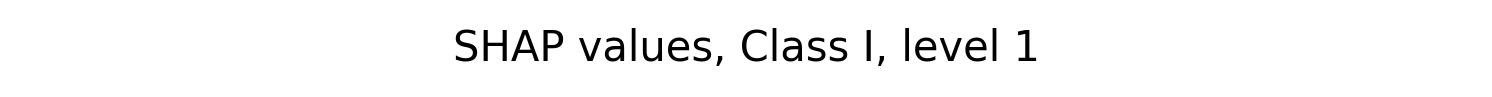

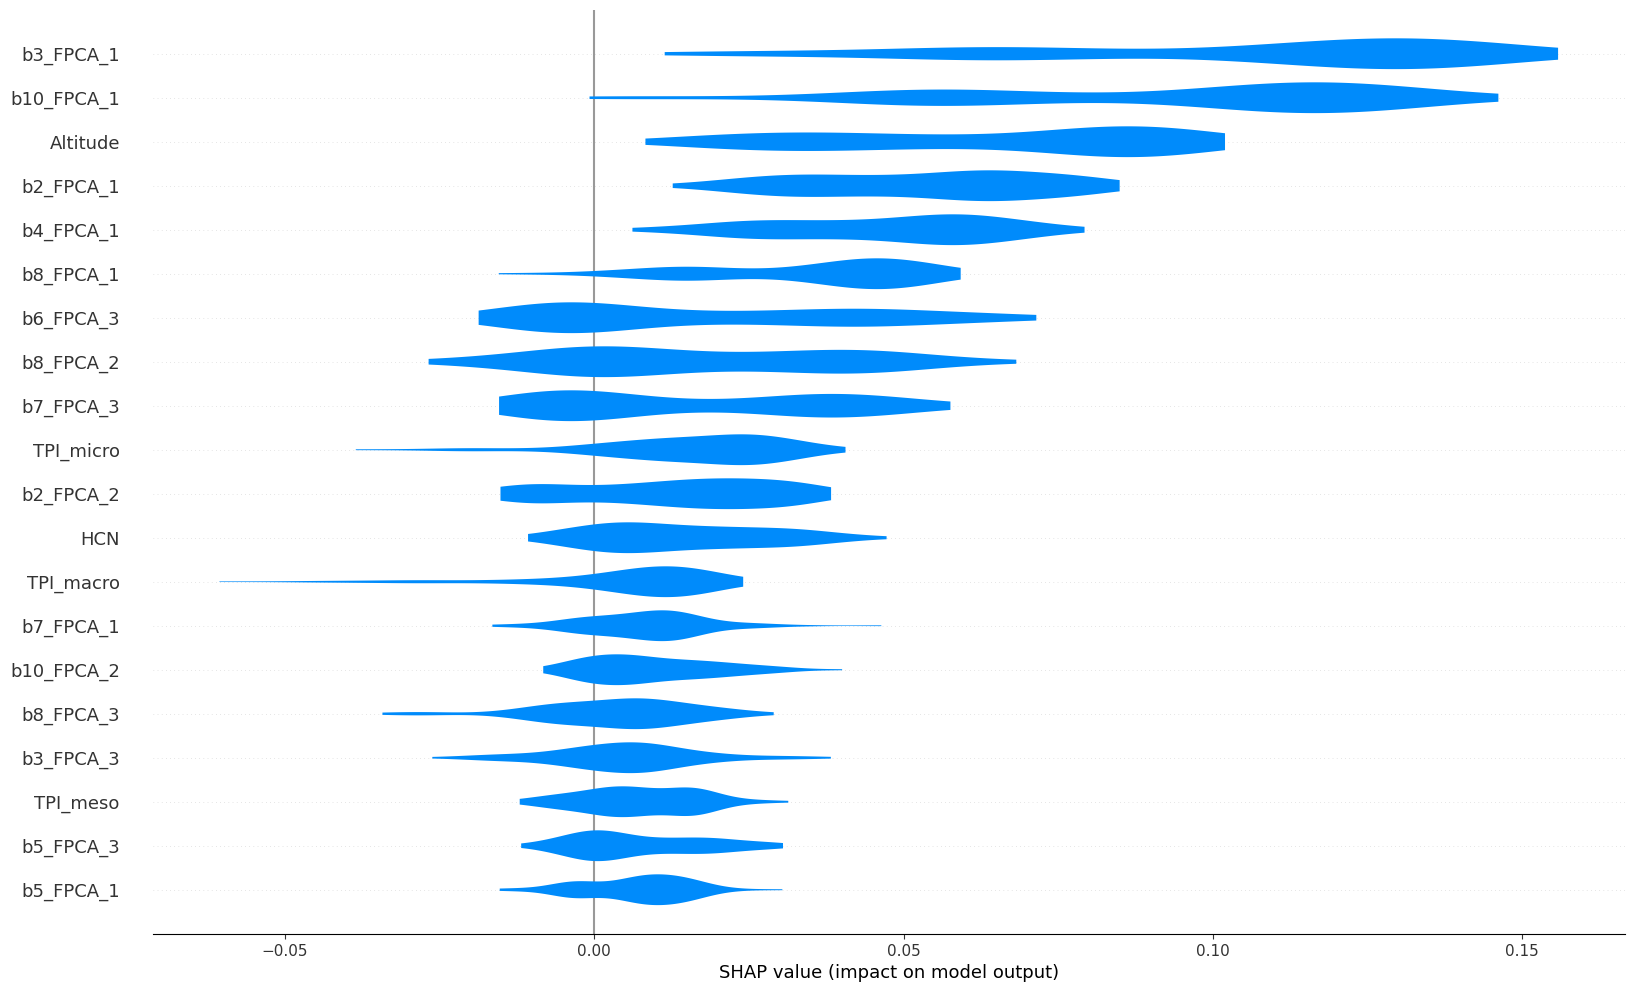

In [62]:
#### SHAP VALUES FOR SPECIFIED CLASS AND LEVELS

import shap

shapclass = 'I'
level = 0

# Filter samples which only predicted "A" at first level
class_idx = y_pred[:, level] == shapclass

# Specify additional filters to obtain only level 0
shap_filter = {"level": level, "class": shapclass, "sample": class_idx}

# Use .sel() method to apply the filter and obtain filtered results
shap_val_class = explanations.sel(shap_filter)

# Set font size and print large text
plt.figure(figsize=(19, 1))
plt.text(0.5, 0.5, "SHAP values, Class " + shapclass + ", level " + str(level+1), fontsize=30, ha='center', va='center')
plt.axis('off')  # Hide axis
plt.show()

# Plot feature importance on test set
shap.plots.violin(
    shap_val_class.shap_values,
    feature_names=df.columns.values,
    plot_size=(19, 12),
    title = "Class " + shapclass + ", level " + str(level+1)
)


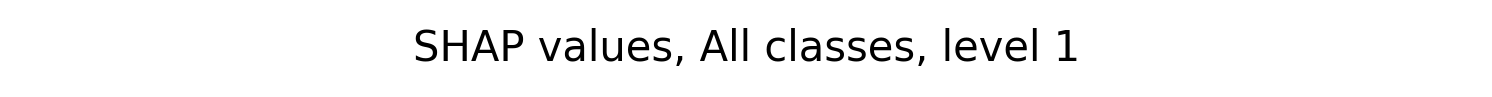

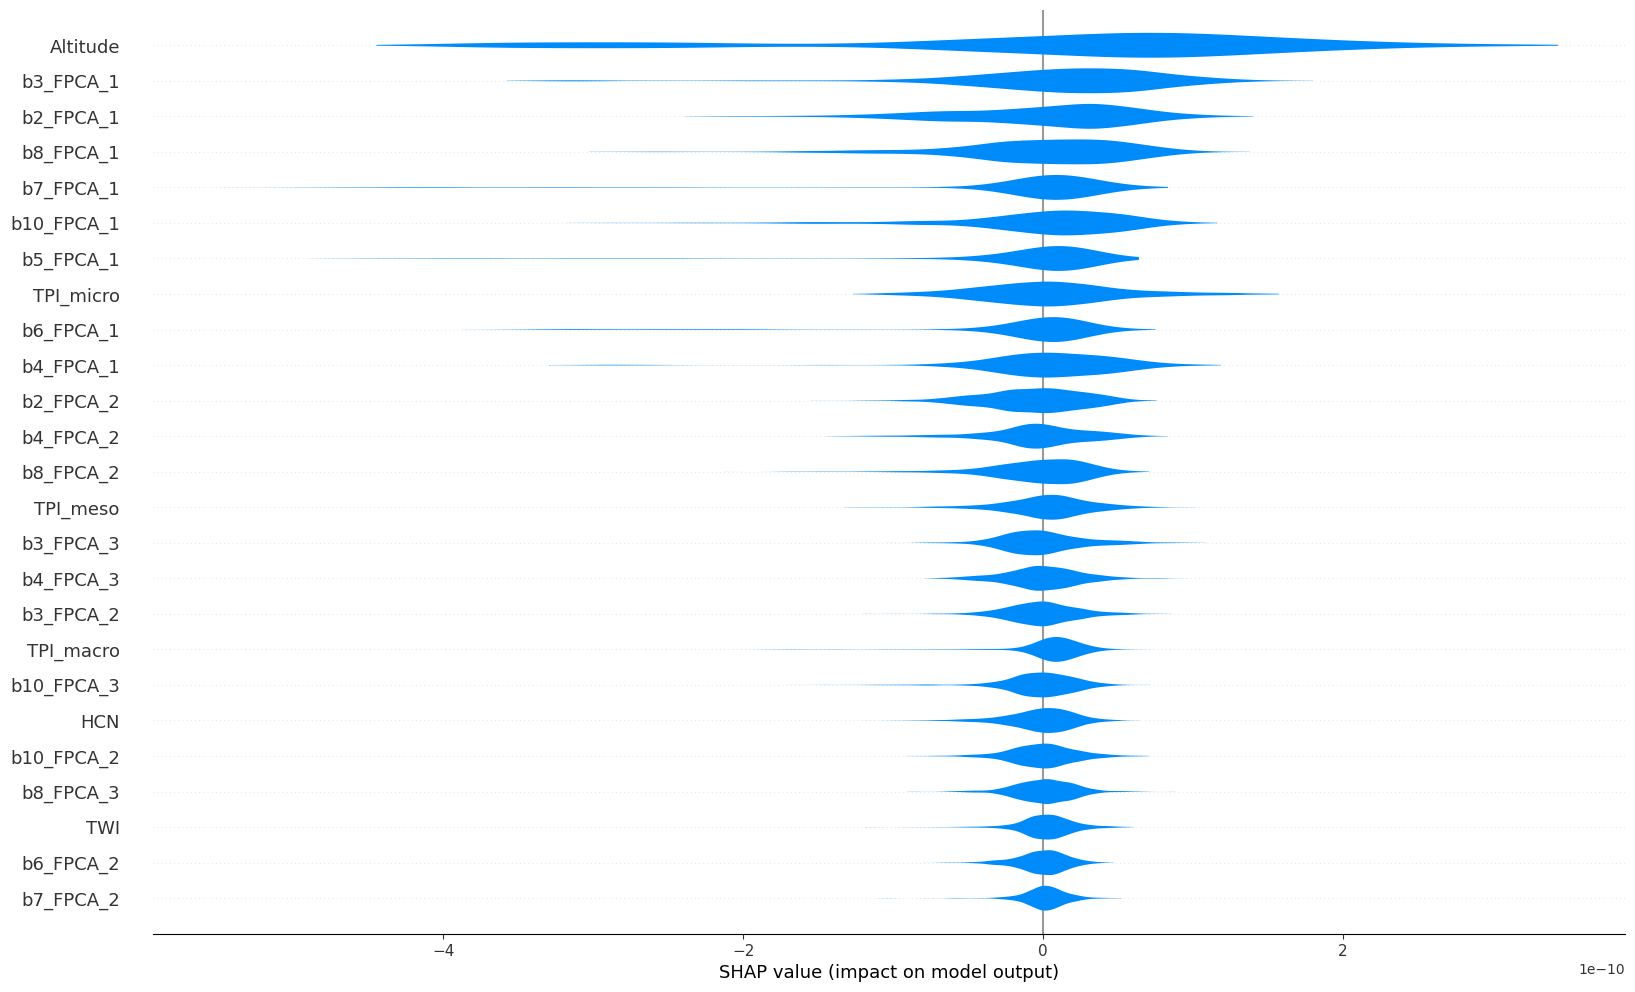

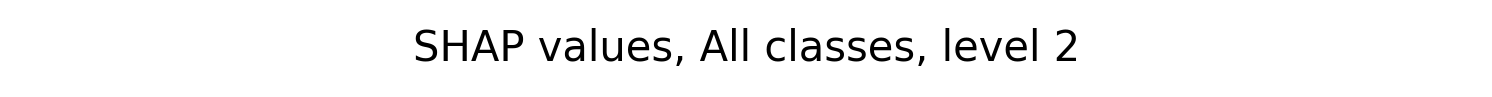

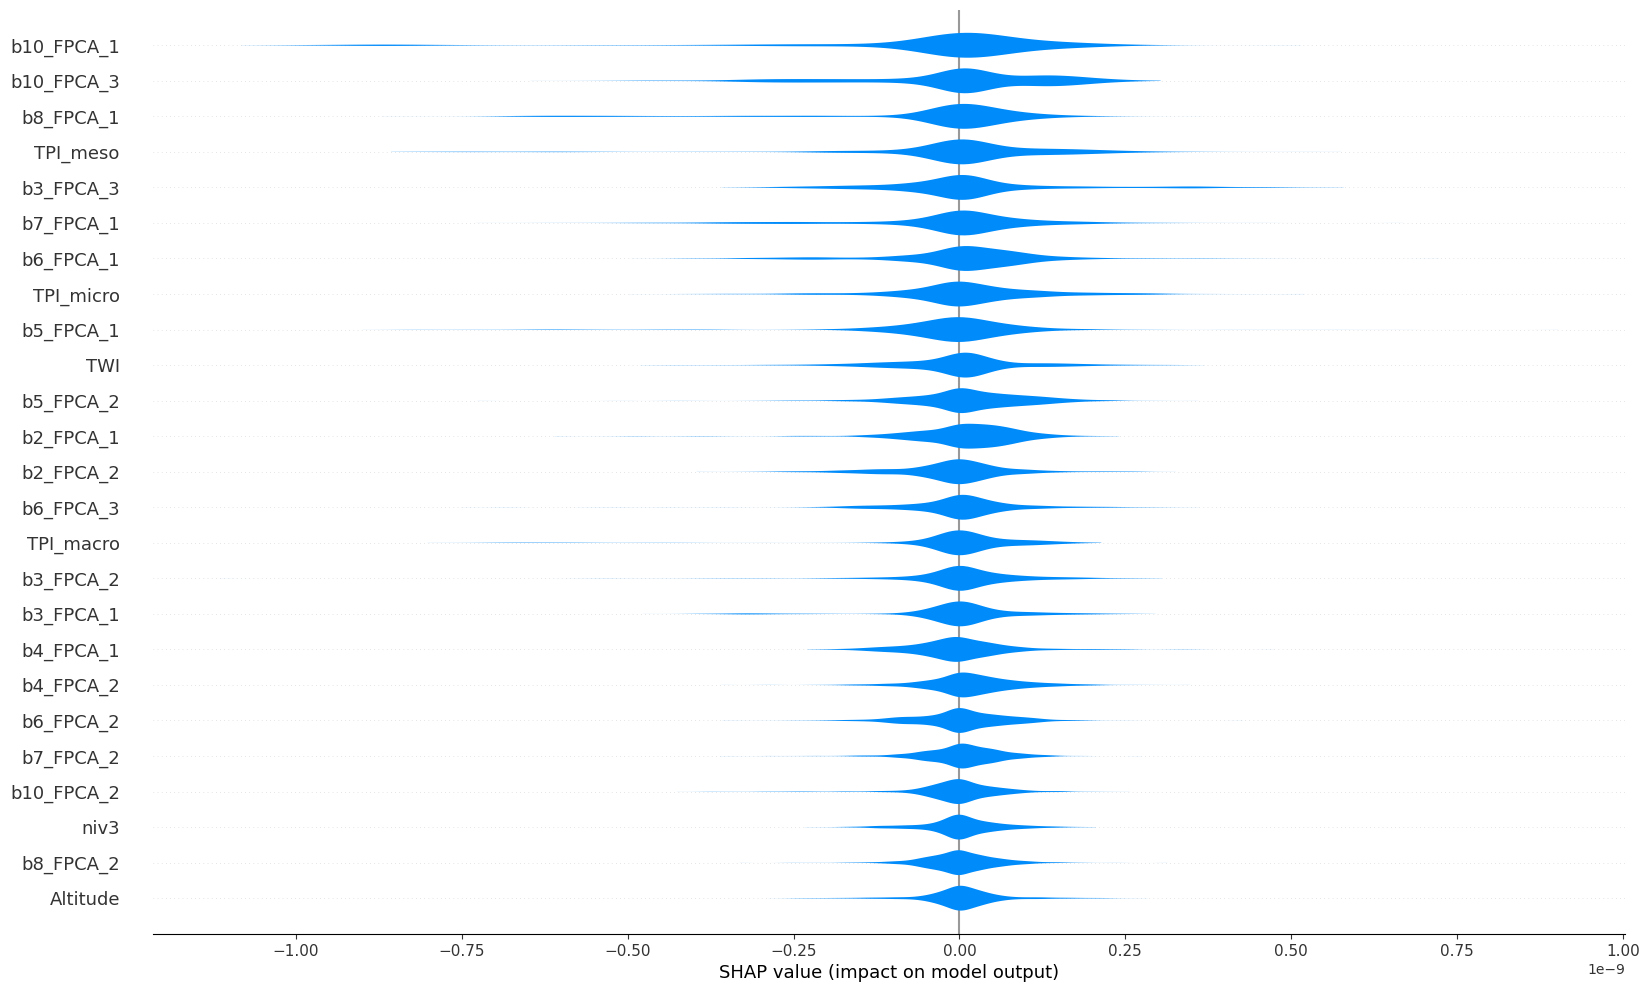

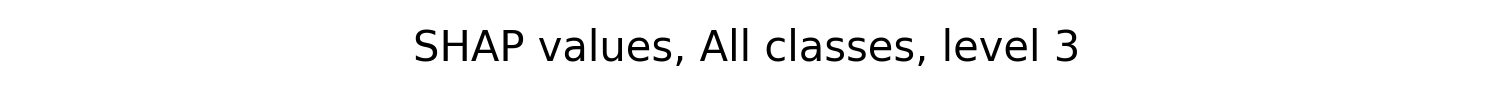

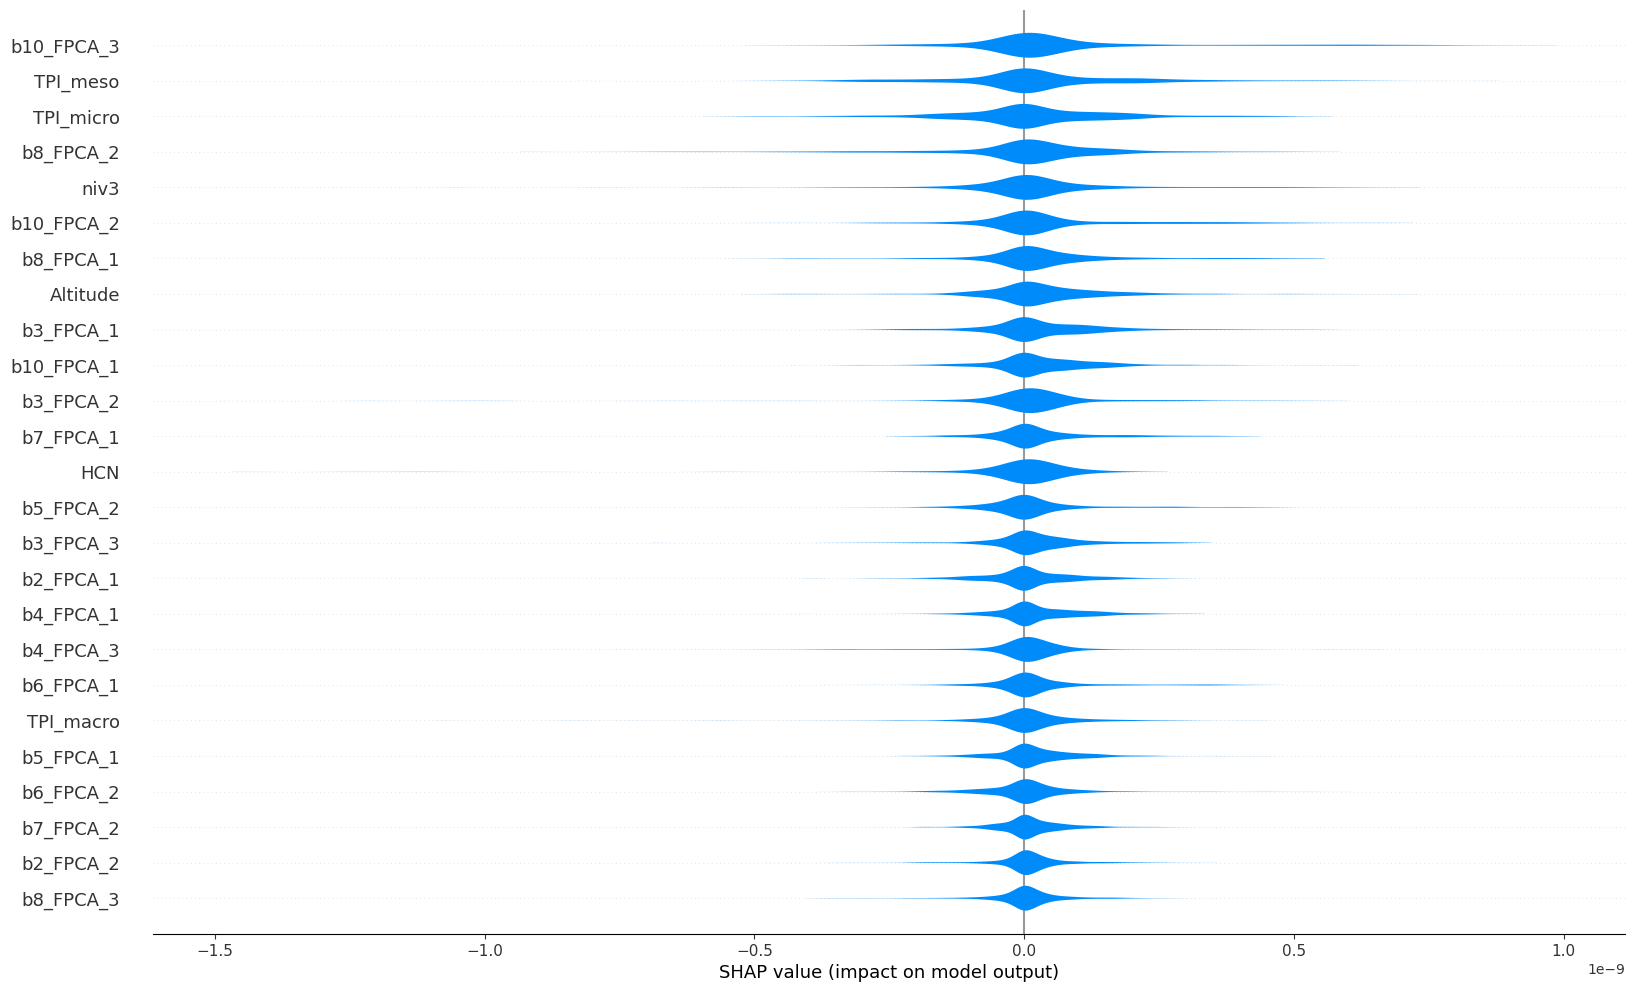

In [63]:
#### MEAN SHAP VALUES ON ALL CLASSES, FOR EACH LEVEL

mean_exp = explanations.mean(dim=['class'])

for i in range(len(ylabel)) : 

    shap_filter = {"level": i}
    
    # Use .sel() method to apply the filter and obtain filtered results
    shap_val_class = mean_exp.sel(shap_filter)
    # Set font size and print large text
    plt.figure(figsize=(19, 1))
    plt.text(0.5, 0.5, "SHAP values, All classes, level " + str(i+1), fontsize=30, ha='center', va='center')
    plt.axis('off')  # Hide axis
    plt.show()
    # Plot feature importance on test set
    shap.plots.violin(
        shap_val_class.shap_values,
        feature_names=df.columns.values,
        plot_size=(19, 12),
        title = "All classes, level " + str(i+1),
        max_display = 25
    )



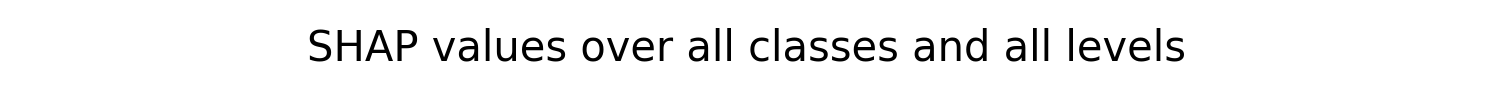

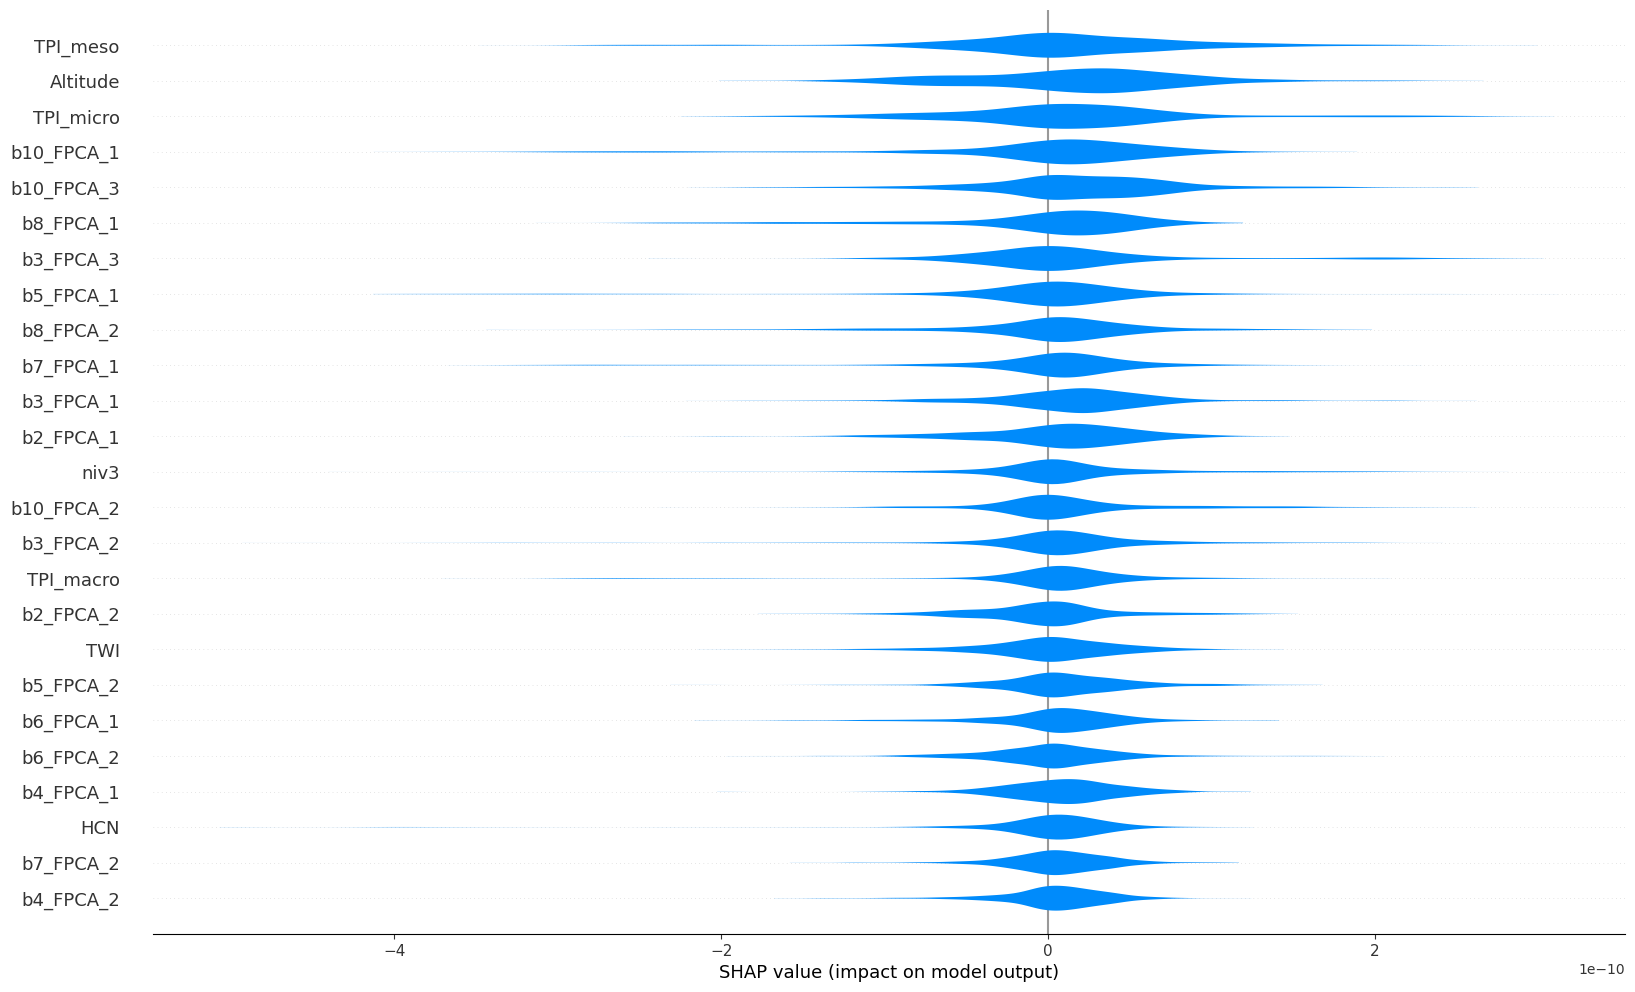

In [64]:
#### MEAN SHAP VALUES ON ALL CLASSES AND LEVELS

mean_exp = explanations.mean(dim=['class'])

# Set font size and print large text
plt.figure(figsize=(19, 1))
plt.text(0.5, 0.5, "SHAP values over all classes and all levels", fontsize=30, ha='center', va='center')
plt.axis('off') 
plt.show()

# Plot feature importance on test set
shap.plots.violin(
    mean_exp.mean(dim=['level']).shap_values,
    feature_names=df.columns.values,
    plot_size=(19, 12),
    max_display = 25
)

# Save model using pickle

In [65]:
import pickle 

pickle.dump(classifier, open(modelpath, "wb"))

# to open the model later: classifier = pickle.load(open(modelpath, "rb"))


# Perform predictions on raster

In [66]:
# Turn the raster into a 1 dimensional array for predictions, saving it's original shape and coords for reassembling later on
# reshapes array to (values, bands) instead of (bands, values) before applying .predict()
shape = im.shape
coords = im.coords
dims = im.dims

im_1d = im.values.reshape(shape[0], shape[1] * shape[2])
im_1d_np = np.zeros((shape[1] * shape[2], shape[0]))
for i in range(shape[0]):
    im_1d_np[:,i] = im_1d[i]
im_1d = im_1d_np
del(im_1d_np)

# Perfom predictions 
pred_1d = classifier.predict(im_1d)


In [90]:
### CLass labels are given as U51 string values, to save them as rasters we have to convert them to int values 
# We generate a dictionary to allocate each class an integer value 
strmod = np.unique(pred_1d)
intmod = np.array(range(len(np.unique(pred_1d))))

modalities_dict = dict(zip(strmod, intmod))
# The modalities_dict variable allows to see the equivalences between each class and their attributed integer value


# In a new data array we translate the classified raster from string values to integer values
pred_1d_int = np.zeros(pred_1d.shape, dtype = 'int')
for i in range(pred_1d.shape[0]):
    for j in range(pred_1d.shape[1]):
        pred_1d_int[i,j] = modalities_dict[pred_1d[i, j]]


# Reshape classified raster back to (bands, values) format  
pred_np = np.empty((pred_1d_int.shape[1], pred_1d_int.shape[0]), dtype= 'int')
for i in range(pred_1d_int.shape[1]):
    pred_np[i] = pred_1d_int[:, i]
pred_1d_int = pred_np
del(pred_np)


# Reshape classified raster back to a 3d georeferenced array with shape (band, y, x)
pred_3d = xr.DataArray(pred_1d_int.reshape(pred_1d_int.shape[0],shape[1], shape[2] ), 
                       dims= dims,
                       coords={'band' : np.array(range(pred_1d_int.shape[0])), 'y' : coords['y'],'x' : coords['x'],'spatial_ref' : coords['spatial_ref']})

# Mask classified raster with the original nan mask, originally missing values will be given -1 value 
pred_3d = pred_3d.where(~nan_mask, -1)


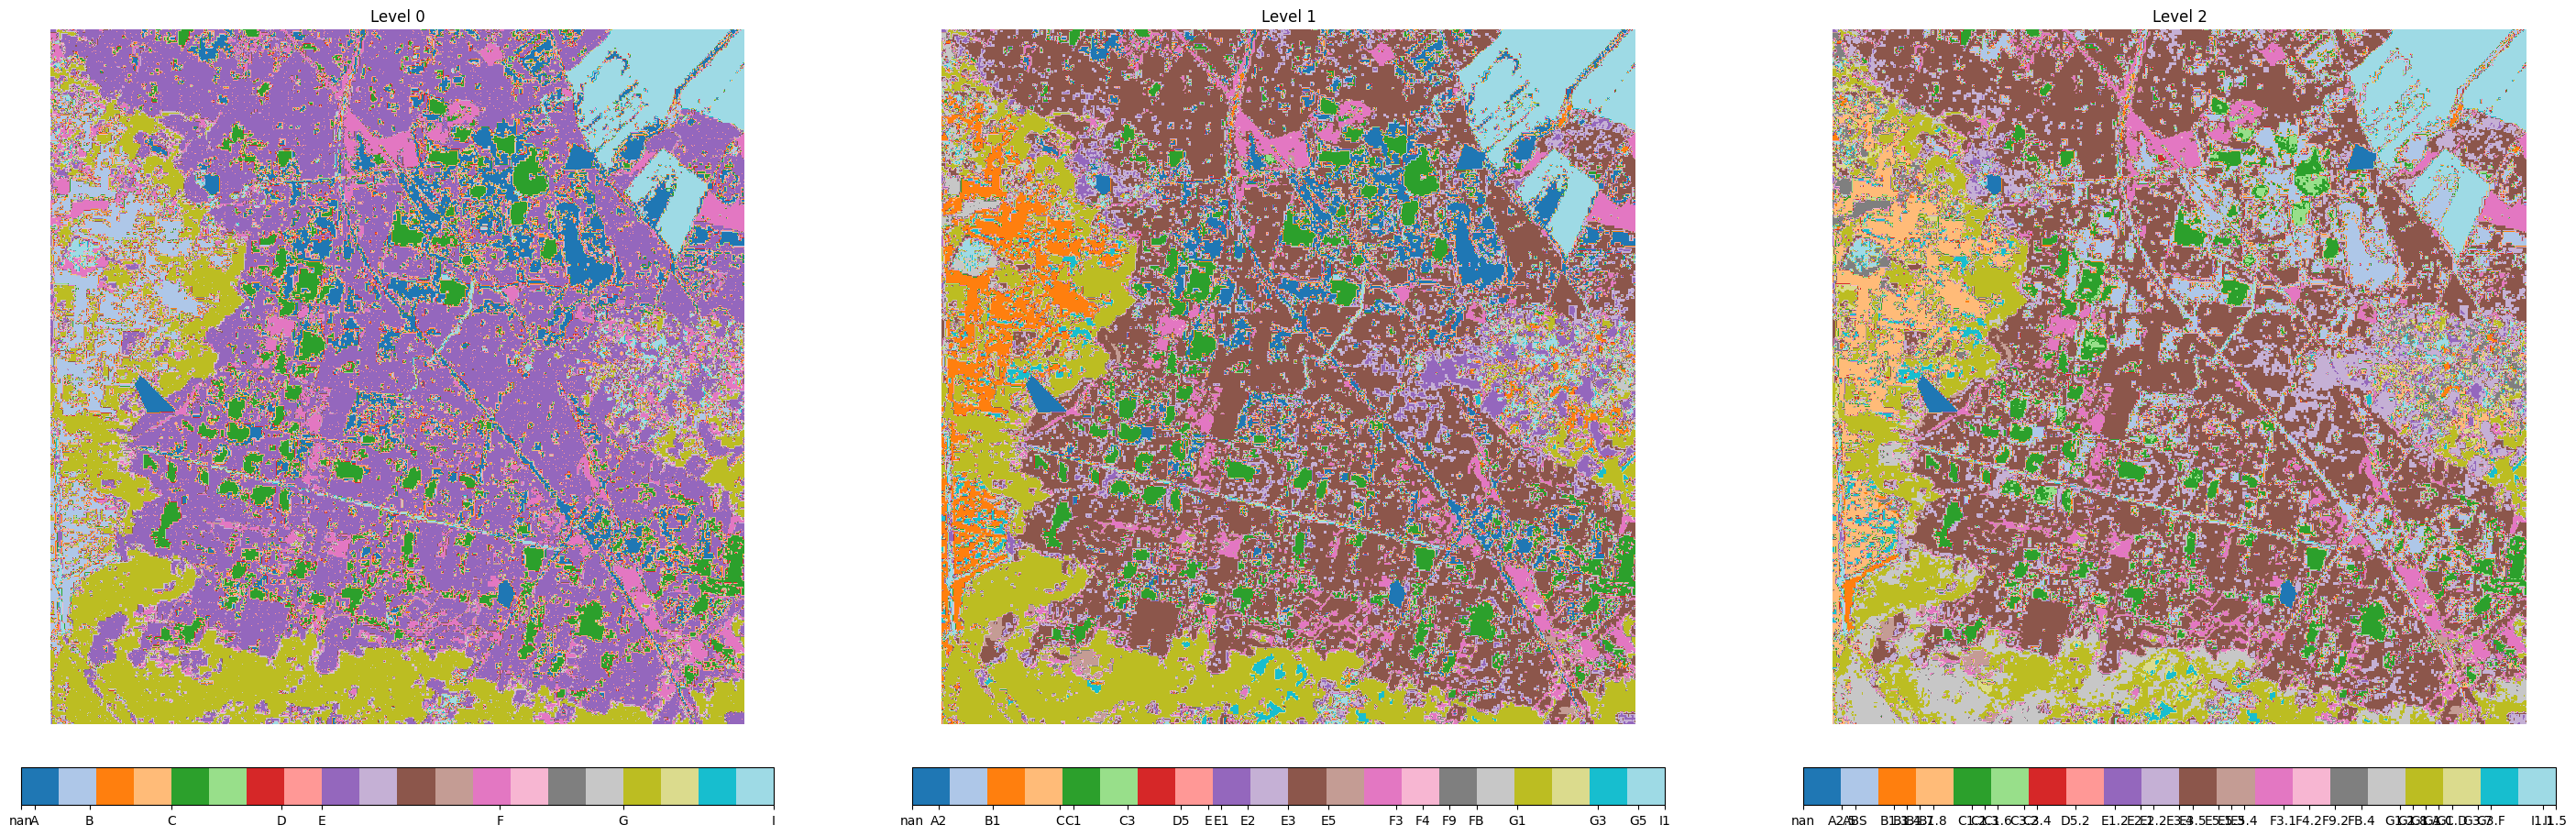

In [98]:
# Display classified raster

import matplotlib.pyplot as plt

# Create a separate subplot for each band
fig, axs = plt.subplots(1, len(ylabel), figsize=(30, 10))

# Iterate over each band and plot it
for i, band in enumerate(pred_3d.coords['band']):
    if nan_mask.any() : 
        labels = np.insert(np.unique(pred_1d[:,i]), 0, 'nan')
    else : 
        labels = np.unique(pred_1d[:,i])
    
    ax = axs[i]
    img = pred_3d.sel(band=band)
    ime = ax.imshow(img, cmap='tab20')
    ax.set_title(f'Level {i}')
    ax.axis('off')  # Turn off axis

    # Create colorbar with corresponding ticks and labels
    cbar = fig.colorbar(ime, ax=ax, ticks=np.unique(img), orientation='horizontal', shrink=0.8,pad=0.05)
    cbar.ax.set_xticklabels(labels)  

# Show the plot
plt.tight_layout()
plt.show()

# Exporting classified raster and class dictionary 

The output classified map is a multiband raster file with as many bands as hierarchical levels in the training data, the classes are expressed as integer values.

The class dictionary is a .csv file giving the equivalences between the integer values of the output raster map and the labeled classes of the input training data.

In [100]:
# Saving class dictionary as .csv
class_dict = pd.DataFrame(modalities_dict.items(), columns=['Class', 'Value'])
class_dict.to_csv(classdictpath, index=False)

# Saving classified raster
pred_3d.rio.to_raster(outraster)